# Capstone Project - Orlando Venues with Crime Locations

# Section 1: Introduction

## Description of the Problem

### Background

There are numerous travel sites scattered about the Internet, FourSquare being on of these, that give you various information pertaining to, restaurants, bars, nightclubs, where to get  breakfast and a good cup of coffee in the morning. The problems with these sites is usually only detail one aspect of the venue. The venue may be most popular place for a night out but it doesn't mean that a tourist or someone new to the city should automatically visit the venoue without more information. The areas surrounding the venue may be a high crime area including robbery, drug activity and assault as examples. These factors may fluctuate depending on timing of proposed visit. The idea of this project is to provide the information pertaining to the venue but coupling this data with crime data to better inform the prospective customer with readily available data to make an informed and safe decision for an enjoyable experience. 

### Project Concept

The concept for this project is to provide visitors to the Orlando area, venues based upon the the FourSquare API query and accompanied with crime data, venue options that they can feel comfortable and safe with their families or possibly single adult.

The approach will follow the basic approach outlined as follows:

1. The travellers decides on a city location. (this case being Orlando, FL)
2. The ForeSquare website is scraped for the top venues in Orlando
3. The list of venues is supplied with geographical data
4. Historical crimes within a given distance of all venues are presented
5. A map is produced showing the selected venues and crime statistics in the area
6. The probability of a crime ocurring near the selected top sites is also presented


### Target Audience

The target audience of htis project is the 10's of thousands or visitors to the Orlando, FL area. The weather and many attractions, including Disney World and Universal Studios, which are consistently in the top attractions of the US, produce many visitors that are not familiar with the local area every year. Along with these transactions there are thousands or restaurants and night clubs for the enjoyment of visitors, but not always in the most family or single visitor safe areas. These visitors include the elderly and single female persons that tend to let there "guard down" when visiting the area.

### Import libraries

In [66]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes &>/dev/null 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium --yes &>/dev/null
import folium # map rendering library


print('Libraries imported.')

Libraries imported.


### Setup credentials for call of the FourSquare API

In [67]:
CLIENT_ID = 'VEC3NZNS5L2KNODCHV3PF10JUXKS32QT4NJ1EQK4ROWBZVXS' # your Foursquare ID
CLIENT_SECRET = 'Q40CAFX222FY32FNK1QA113KP3QT0P2R0C45LWIXDXIVLJ53' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VEC3NZNS5L2KNODCHV3PF10JUXKS32QT4NJ1EQK4ROWBZVXS
CLIENT_SECRET:Q40CAFX222FY32FNK1QA113KP3QT0P2R0C45LWIXDXIVLJ53


### Retrieve Orlando, FL latitude and longitude

In [68]:
address = 'Orlando, FL'

geolocator = Nominatim(user_agent="orlando_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Orlando, FL are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Orlando, FL are 28.5421109, -81.3790304.


# Section 2: Data

### FourSquare Data

Setup URL and parameters for FourSquare API call

The top **500** most popular venues, as determined by the FourSquare API, will be extracted using the FourSquare API for Orlando, FL. 

In [69]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [70]:
LIMIT = 500 # limit the number of venues returned from Foursquare
radius = 4000 # define radius
sortByPopularity = 1
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    sortByPopularity)

# get the result to a json file
results = requests.get(url).json()

#### Convert json to Pandas Dataframe

In [71]:
from pandas.io.json import json_normalize 
venues = results['response']['groups'][0]['items']

nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.tail()

,name,categories,lat,lng
95,Lineage Coffee Roasting,Coffee Shop,28.553285,-81.366143
96,GB's Bottle Shop & Tasting Bar,Beer Store,28.564166,-81.370532
97,The Greenery Creamery,Ice Cream Shop,28.540599,-81.372084
98,Jason's Deli,Food Truck,28.515626,-81.377278
99,Lazy Moon Pizza,Pizza Place,28.553541,-81.366007


# Section 3: Methodology

## Using the data from FourSqaure and the Orlando police department create maps showing venues and incidents of crime in the vicinity of the venues

### Create Map of Orlando, Fl - place markers representing venues returned by FourSquare

Create street level map of Orlando, FL and place markers for the Venues returned by FourSquare API with popup ability that shows user the name and category of the venure selected.

In [ ]:
# create map of Orlando using latitude and longitude values
map_Orlando = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'],nearby_venues['categories'] ):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Orlando)  
    
map_Orlando

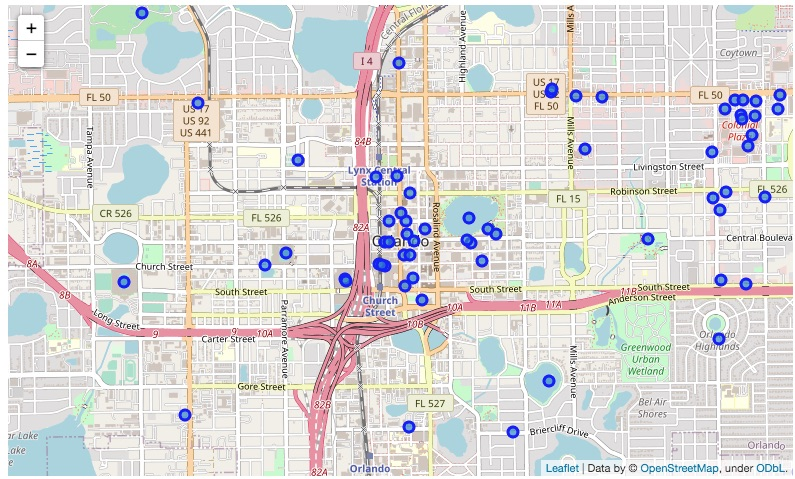

### Description of the FourSquare data

#### Top 10 Categories of the Venues returned by FourSquare

In [72]:
nearby_venues.categories.value_counts().head(10)

Park                   7
Bar                    7
Restaurant             5
Coffee Shop            5
American Restaurant    5
Grocery Store          5
Mexican Restaurant     3
Gay Bar                3
Convenience Store      3
Cosmetics Shop         2
Name: categories, dtype: int64

### Orlando Crime Data

#### Read OPD_Crimes.csv file downloaded from the City of Orlando open data website into pandas dataframe

In [73]:
Orlando_crime = pd.read_csv("OPD_Crimes.csv")
Orlando_crime.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00205861,6/30/20 22:42,9400 Block of JEFF FUQUA BLVD N,Airport,Theft,All other larceny,Committed,Closed,Mapped,"(28.43357994, -81.30536644)"
1,2020-00205808,6/30/20 21:41,S WESTMORELAND DR / W JACKSON ST,Highway/Road/Alley,Narcotics,Drugs/narcotics,Committed,Arrest,Mapped,"(28.53921265, -81.3931697)"
2,2020-00205804,6/30/20 21:33,5900 Block of BENT PINE DR,Parking Lot - Surface,Narcotics,Drugs/narcotics,Committed,Arrest,Mapped,"(28.47388042, -81.30610262)"
3,2020-01002151,6/30/20 20:37,8600 Block of DUFFERIN LN,Parking Garage,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"(28.44083505, -81.24249601)"
4,2020-00205742,6/30/20 20:08,700 Block of HERNDON AVE,Specialty Store,Theft,Shoplifting,Committed,Inactive,Mapped,"(28.55449248, -81.33747305)"


#### Remove spaces from the column names

In [74]:
Orlando_crime.columns = Orlando_crime.columns.str.replace(' ','')

### Description of Orlando Crime data

Data reveals 2398 crimes were unmapped, we will be removing these from the dataset

In [75]:
n = Orlando_crime.Status.value_counts()
n

Mapped      46622
Unmapped     2398
Status          2
Name: Status, dtype: int64

#### Drop unmapped locations

In [76]:
Orlando_crime = Orlando_crime[pd.notnull(Orlando_crime['Location'])]
Orlando_crime.Status.value_counts()

Mapped    46622
Name: Status, dtype: int64

#### Frequency of criminal offenses - Orlando, FL

Here we extract the categories of crimes withe the number of crimes per category (value counts of the categories) and create a dataframe

In [77]:
df_category_counts = Orlando_crime.CaseOffenseCategory.value_counts()
df_category_counts_reset = df_category_counts.reset_index()
df_category_counts_reset.columns = ['Category', 'Count']
df_category_counts_reset

,Category,Count
0,Theft,25363
1,Assault,5597
2,Narcotics,4685
3,Burglary,3571
4,Fraud,3321
5,Vehicle Theft,2665
6,Robbery,1275
7,Homicide,54
8,Arson,46
9,Kidnapping,27


#### Graphical Representation of Crime Data 

Display a bar chart of the crime incidents by category. This showcases that "Theft" is the largest category of crimes by a significant number

In [ ]:
df_category_counts_reset.plot.bar(x='Category', title='Top 10 Crimes by Category', figsize=(14,6))

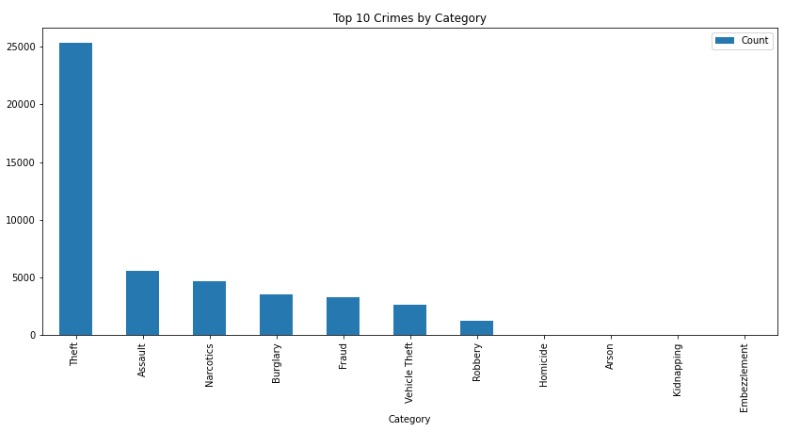

#### Create lists of latitude and longitude to be used in the creation of the HeatMap.

In [78]:
# Create 2 lists for loop to capture latitiude and longitude
lat = []
long = []

for row in Orlando_crime['Location']:
    try:
        lat.append(row.split(',')[0])
        long.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        long.append(np.NaN)
        
Orlando_crime['Latitude'] = lat
Orlando_crime['Longitude'] = long

#### Strip "()" from latitude and longitude fields

In [79]:
Orlando_crime['Latitude'] = Orlando_crime['Latitude'].map(lambda x: x.lstrip('('))
Orlando_crime['Longitude'] = Orlando_crime['Longitude'].map(lambda x: x.rstrip(')'))

#### Cast Latitude and Longitude as floats

In [80]:
Orlando_crime["Latitude"] = Orlando_crime["Latitude"].astype(float)
Orlando_crime["Longitude"] = Orlando_crime["Longitude"].astype(float)

#### Display the first 5 records of the "cleaned" crime dataframe

In [81]:
Orlando_crime.head()

,CaseNumber,CaseDateTime,CaseLocation,CaseOffenseLocationType,CaseOffenseCategory,CaseOffenseType,CaseOffenseChargeType,CaseDisposition,Status,Location,Latitude,Longitude
0,2020-00205861,6/30/20 22:42,9400 Block of JEFF FUQUA BLVD N,Airport,Theft,All other larceny,Committed,Closed,Mapped,"(28.43357994, -81.30536644)",28.433580,-81.305366
1,2020-00205808,6/30/20 21:41,S WESTMORELAND DR / W JACKSON ST,Highway/Road/Alley,Narcotics,Drugs/narcotics,Committed,Arrest,Mapped,"(28.53921265, -81.3931697)",28.539213,-81.393170
2,2020-00205804,6/30/20 21:33,5900 Block of BENT PINE DR,Parking Lot - Surface,Narcotics,Drugs/narcotics,Committed,Arrest,Mapped,"(28.47388042, -81.30610262)",28.473880,-81.306103
3,2020-01002151,6/30/20 20:37,8600 Block of DUFFERIN LN,Parking Garage,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"(28.44083505, -81.24249601)",28.440835,-81.242496
4,2020-00205742,6/30/20 20:08,700 Block of HERNDON AVE,Specialty Store,Theft,Shoplifting,Committed,Inactive,Mapped,"(28.55449248, -81.33747305)",28.554492,-81.337473


### Heat map of Crime Date with venues from FourSquare data overlayed - Orlando, FL 

#### Create HeatMap of the crimes in Orlando, FL and overlay upon the venues from earlier

In [82]:
from folium.plugins import HeatMap

In [ ]:
gradient = {.25: 'blue', .50: 'green', 1: 'red'}
HeatMap(data=Orlando_crime[['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, gradient = gradient).add_to(map_Orlando)

map_Orlando

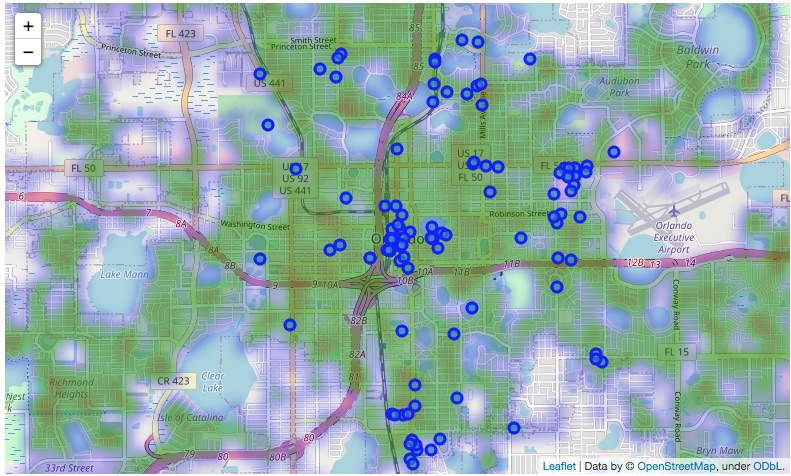

#### Create markers and cluster the crime incidents and overlay upon the HeatMap created prior.

Clusters can be expanded by selected the clusters revelaing smaller clusters until the single markers are visible representing the individual crime. This is then able to be observed in relation to the circle markers representing the venues from FourSquare. 

In [ ]:
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map_Orlando)
for row in Orlando_crime.itertuples():
    folium.Marker(location=[row.Latitude, row.Longitude], popup=row.CaseOffenseCategory).add_to(marker_cluster)
map_Orlando

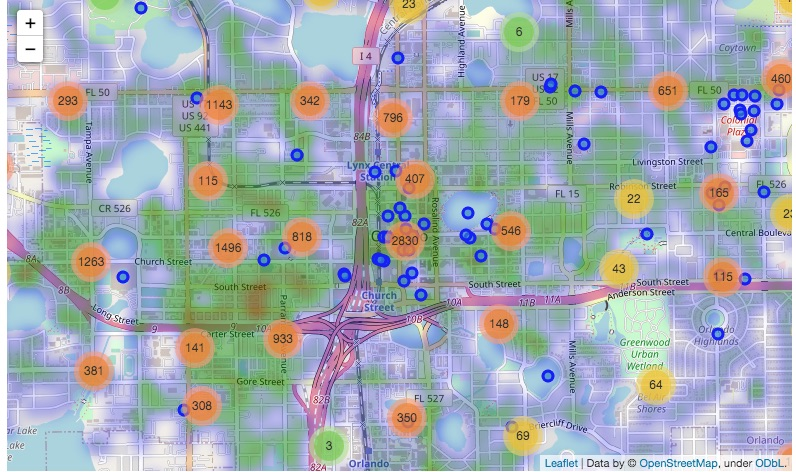

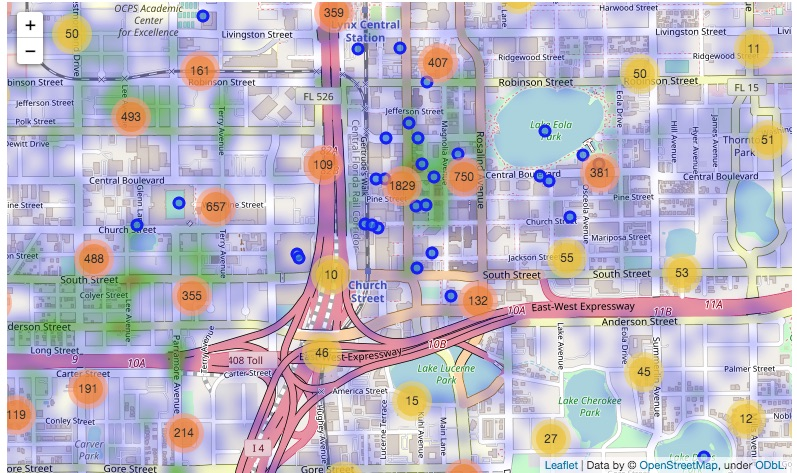

## Section 4: Results

The data of popular venues in the Orlando, FL downtown area, as determined by the FourSquare API, combined with the crime incidents data provided via the Orlando Police department revealed that the majority of crime is in close vicinity to the center of the city. The data exposed that the majority of the crime is of a non-violent nature such as Theft. 

## Section 5: Discussion

The purpose of this endeavor was to determine the most popular venues in Orlando, FL based upon the information gathered via the FourSquare API and mark these locations on a city map for the user. Secondly, to map the ciminal incidents in the city of Orlando with the data provided from the Orlando police department. The goal of this effort was to allow vistiors or anyone unfamiliar with the Orlando, FL area to first determine popular venues in the area that they may desire to visit and to associate the level of criminal activity in the proximity of the selected venue. The results from above allow the user to easily identify the popular venues in the Orlando area and easily determine the risk factor associated with attending that specific venue in regards to historical crime incidents. 

## Section 6: Conclusion

The observation that results from the analysis of the FourSquare and police department data is that the majority of criminal activity in the Orlando, FL area is centralized in the downtown area and that this criminal activity tends to be of the "non-violent" crimes such as Theft. Visitors to these areas should take caution, be aware of surroundings and safeguard valuable items. The visitor of the area should be aware of the dominance of crimes such as Theft they can feel reasonable safe in their physical well-being as violent crime is low. Individuals can enjoy the area with situational awareness while attending the venues of the Orland, FL area. 